In [71]:
import spinmob as s
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import scipy.optimize as opt
import os
import mcphysics as m
import seaborn as sns
import astropy.constants as const
import astropy.units as u

# make plt plot inline
%matplotlib inline

1. conda install pip spyder pyqtgraph
2. pip install spinmob mcphysics imageio sounddevice

## Loading in the data

Calibration & Lead runs

In [3]:
user_path = '/Users/oliviapereira/Desktop' if (os.path.isdir('/Users/oliviapereira')) else '/Users/audrey/Documents/PHYS469'
folder_path = user_path + '/PHYS469/alpha_decay/raw_data/'  # path to data folder

am_data = m.data.load_chn(folder_path + 'am_source.chn')
pb_data = m.data.load_chn(folder_path + '11262024_longrun.Chn')
calibration_data = m.data.load_chn(folder_path + 'calibration_new/channel_counts.chn')

channels = calibration_data.columns['Channel']
am_counts = am_data.columns['Counts']
pb_counts = pb_data.columns['Counts']  
pulser_counts = calibration_data.columns['Counts'] 

In [4]:
pb_data.headers

{'description': 'EQ1032 preamp, 1500millitorr, Am sample, bi-amp',
 'start_time': {'year': 2024,
  'month': 11,
  'day': 19,
  'hour': 13,
  'minute': 3,
  'second': 2,
  'year_day': 324},
 'real_time': 595784.58,
 'live_time': 595782.78,
 'path': '/Users/audrey/Documents/PHYS469/PHYS469/alpha_decay/raw_data/11262024_longrun.Chn'}

Pressure runs

In [5]:
pressure_data_dict = {}
for file in os.listdir(folder_path + 'pressure_new/'):
    p = file.split('.')[0]
    pressure_data_dict[p] = m.data.load_chn(folder_path + 'pressure_new/' + f'{p}.Chn')

pressure_data_dict.keys()

dict_keys(['50mbar', '175millitorr', '250mbar', '100mbar', '150mbar', '200mbar', '2000millitorr', '80millitorr', '400millitorr'])

## Adding in new calibration runs

In [6]:
folder_path = user_path + '/PHYS469/alpha_decay/raw_data/calibration_new'

# making an array of channel-voltage pairs, where the channel is the file name and the voltage is the peak y value in each file 
# txt files, headers are on row 29

# get all the files in the folder
files = os.listdir(folder_path)

# sort the files by channel number
files.sort()
files.remove('channel_counts.Chn')

# initialize the array
pulser_voltages = []
pulser_channels = []

# loop through the files
for file in files:
    # read the file
    data = np.genfromtxt(folder_path + '/' + file, skip_header=29)
    # get the peak y value
    peak = max(data[:,1])
    # # get the channel number
    channel = int(file.split('.')[0])
    # # add the pair to the array
    pulser_voltages.append(peak)
    pulser_channels.append(channel)

voltage_err = 0.0001

## Creating the energy scale

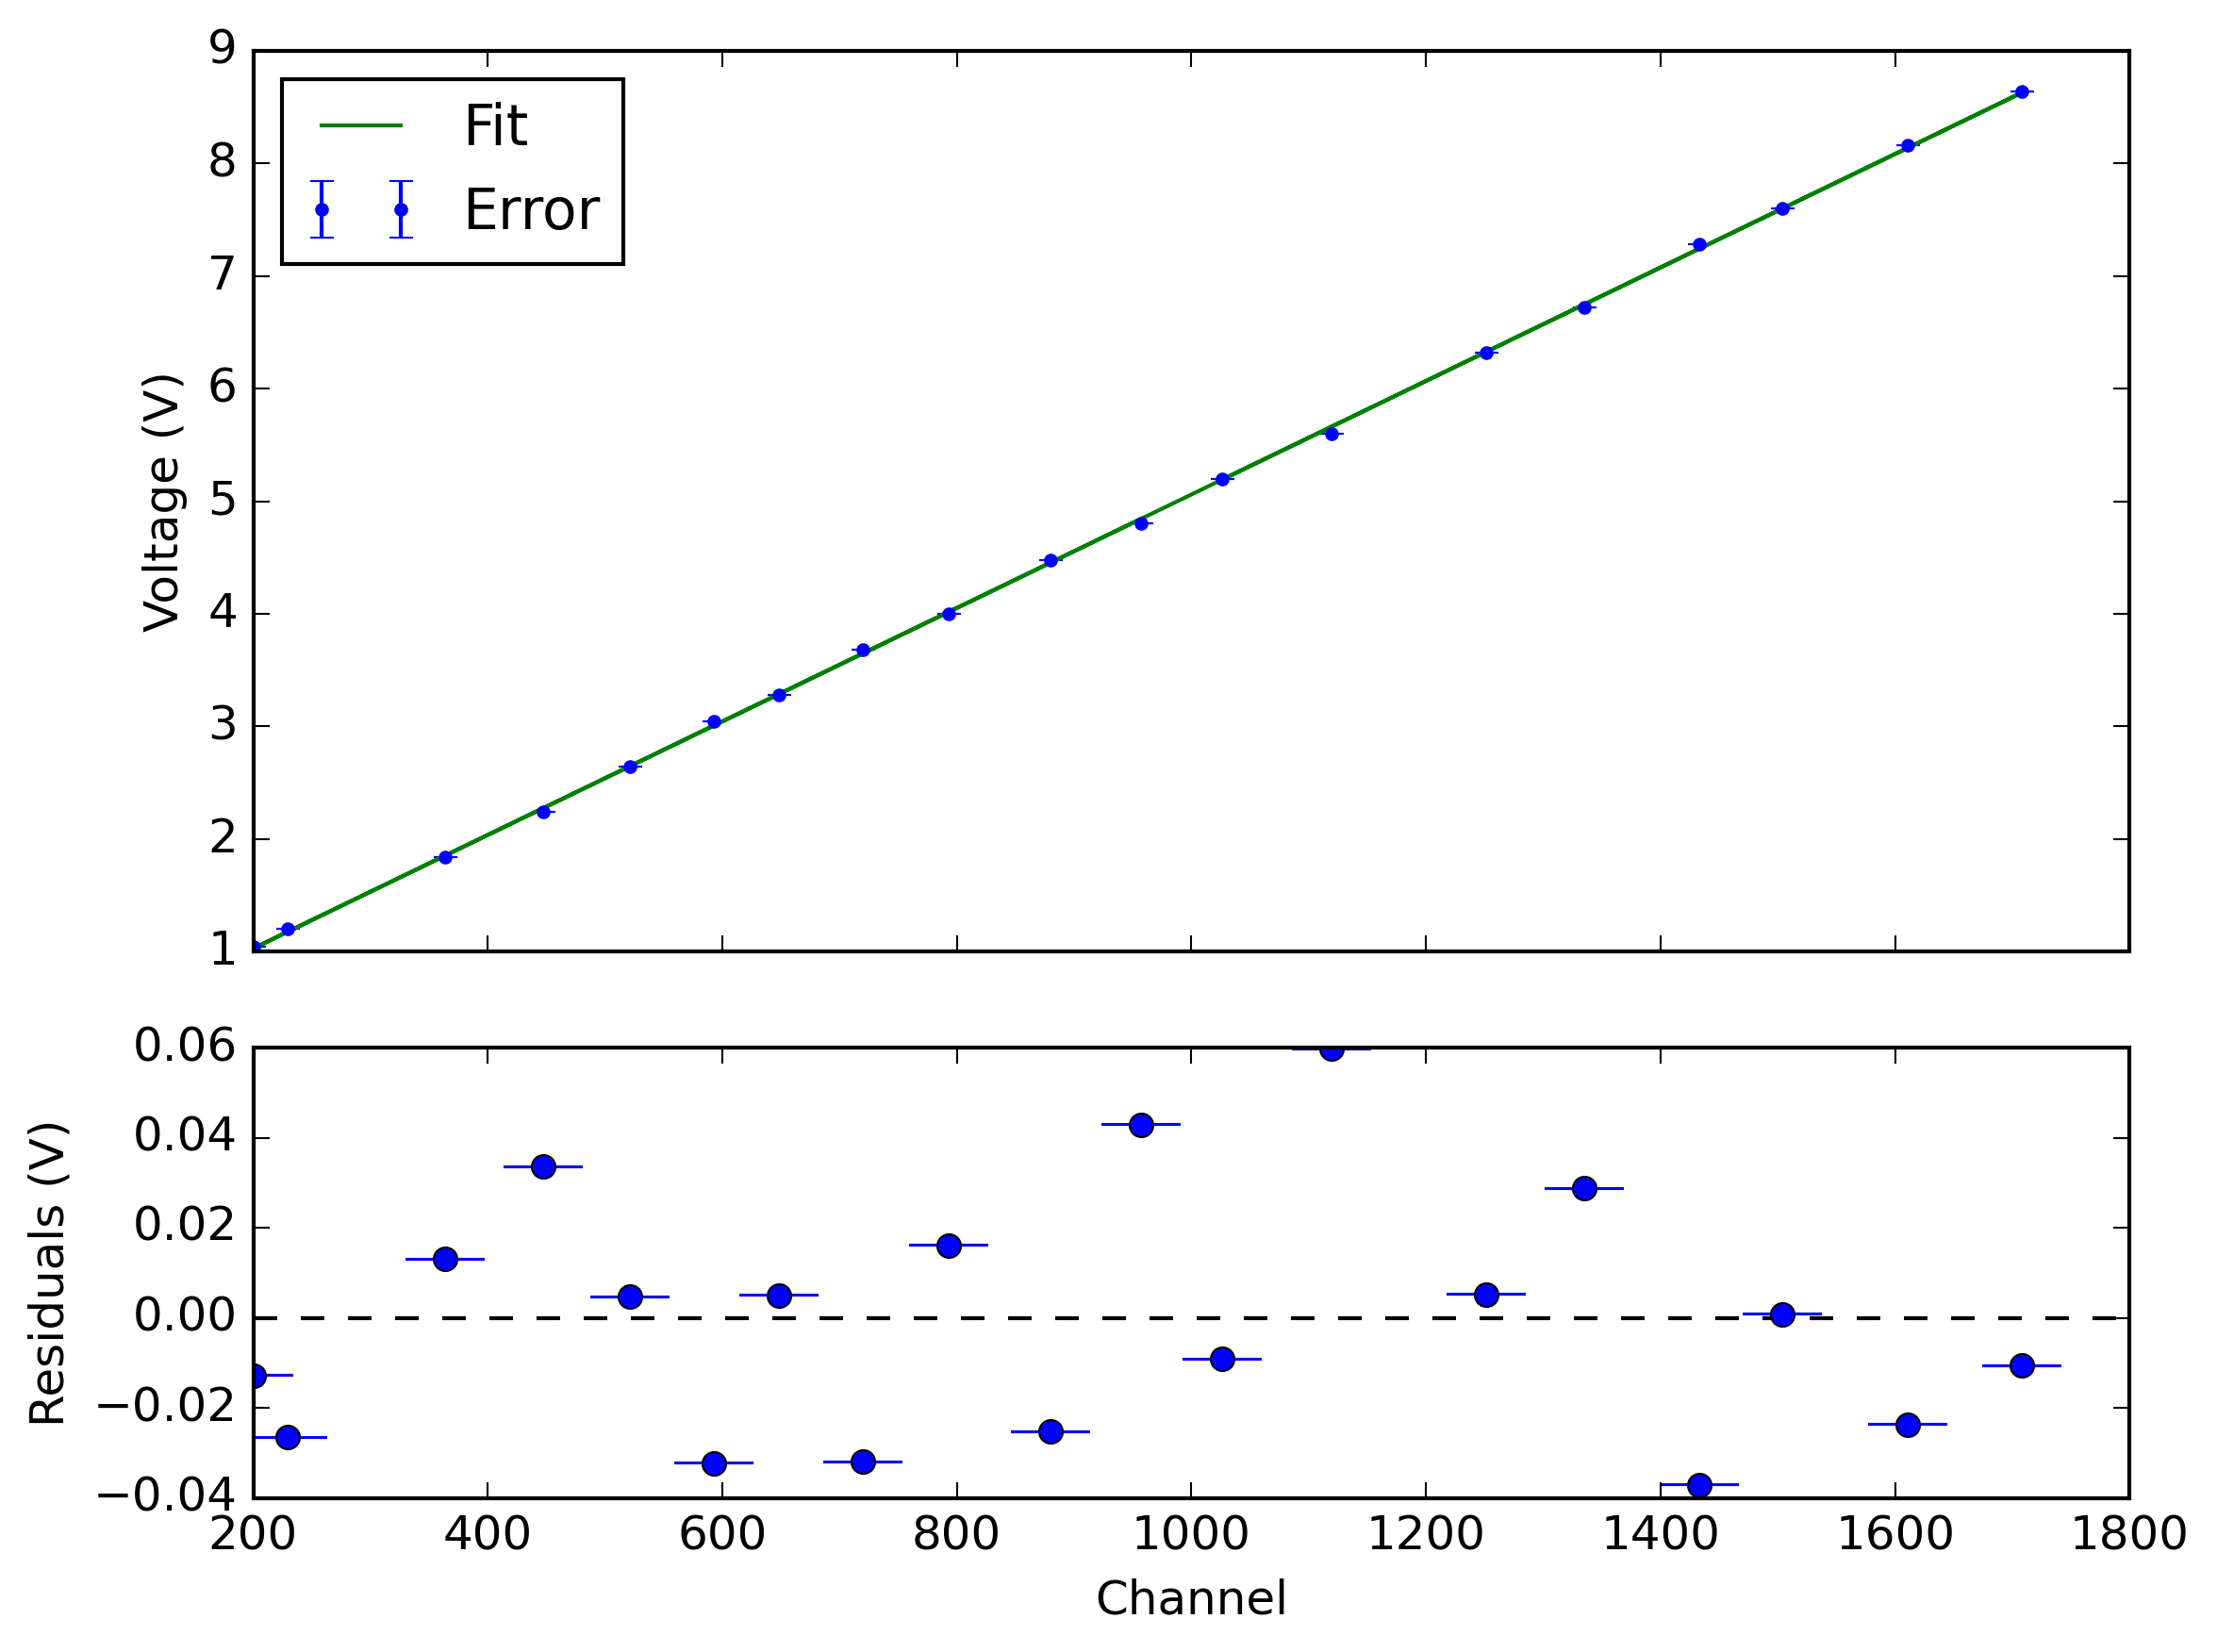

In [7]:
def line(channels, m, b):
    channels = np.array(channels)
    return m * channels + b

# using the Americium to get a known point: 
am_peak = np.where(am_counts == np.max(am_counts))[0][0]

# fit the calibration data
popt, pcov = opt.curve_fit(line, pulser_channels, pulser_voltages, p0=[1, 0])
m, b = popt
m_err = np.sqrt(pcov[0,0])
b_err = np.sqrt(pcov[1,1])

# plot the fit and residuals
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(8, 6), dpi = 300, gridspec_kw={'height_ratios': [2, 1]})

# Main plot
ax1.errorbar(pulser_channels, pulser_voltages, yerr=voltage_err, fmt='.', label='Error')
ax1.plot(pulser_channels, line(pulser_channels, m, b), label='Fit')
ax1.set_ylabel('Voltage (V)')
ax1.legend(loc = 'upper left')

# Residuals plot
ax2.errorbar(pulser_channels, line(pulser_channels, m, b) - pulser_voltages, yerr=voltage_err, fmt='o', capsize = 10)
ax2.axhline(0, color='black', linestyle='--')
ax2.set_xlabel('Channel')
ax2.set_ylabel('Residuals (V)')

plt.tight_layout()
plt.savefig(user_path + '/PHYS469/alpha_decay/figures/calibration.pdf', bbox_inches='tight')
plt.show()

### Fitting the americium energy

In [54]:
# Converting to energy scale
voltages = m * channels + b

# error propagation from fit onto voltages
voltage_err = np.sqrt(channel**2 * m_err**2 + b_err**2)

am_peak_energy = 5.486 # MeV
am_peak_channel = channels[am_peak]

am_peak_voltage = m * am_peak_channel + b
am_peak_voltage_err = 0.0001 # from measurements

energy = am_peak_energy * voltages / am_peak_voltage
energy_err = energy * np.sqrt((am_peak_voltage_err/am_peak_voltage)**2 + (voltage_err/voltages)**2)

# error on counts = sqrt(counts) for any counts (poisson statistics)

In [9]:
# chi square of our calibration fit
chi2 = np.sum((line(pulser_channels, m, b) - pulser_voltages)**2 / voltage_err**2)
dof = len(pulser_channels) - 2
reduced_chi2 = chi2 / dof

print(f'Chi^2: {chi2}')
print(f'Reduced Chi^2: {reduced_chi2}')

Chi^2: 34.41538035059769
Reduced Chi^2: 2.0244341382704523


## Energy and half-life analysis

The peaks are at channels: [484, 498, 522, 525, 752], corresponding to energies: [5.64819234 5.81038468 6.0884287  6.1231842  8.75301718] +- [0.04564528 0.04564532 0.04564538 0.04564539 0.04564614] MeV.


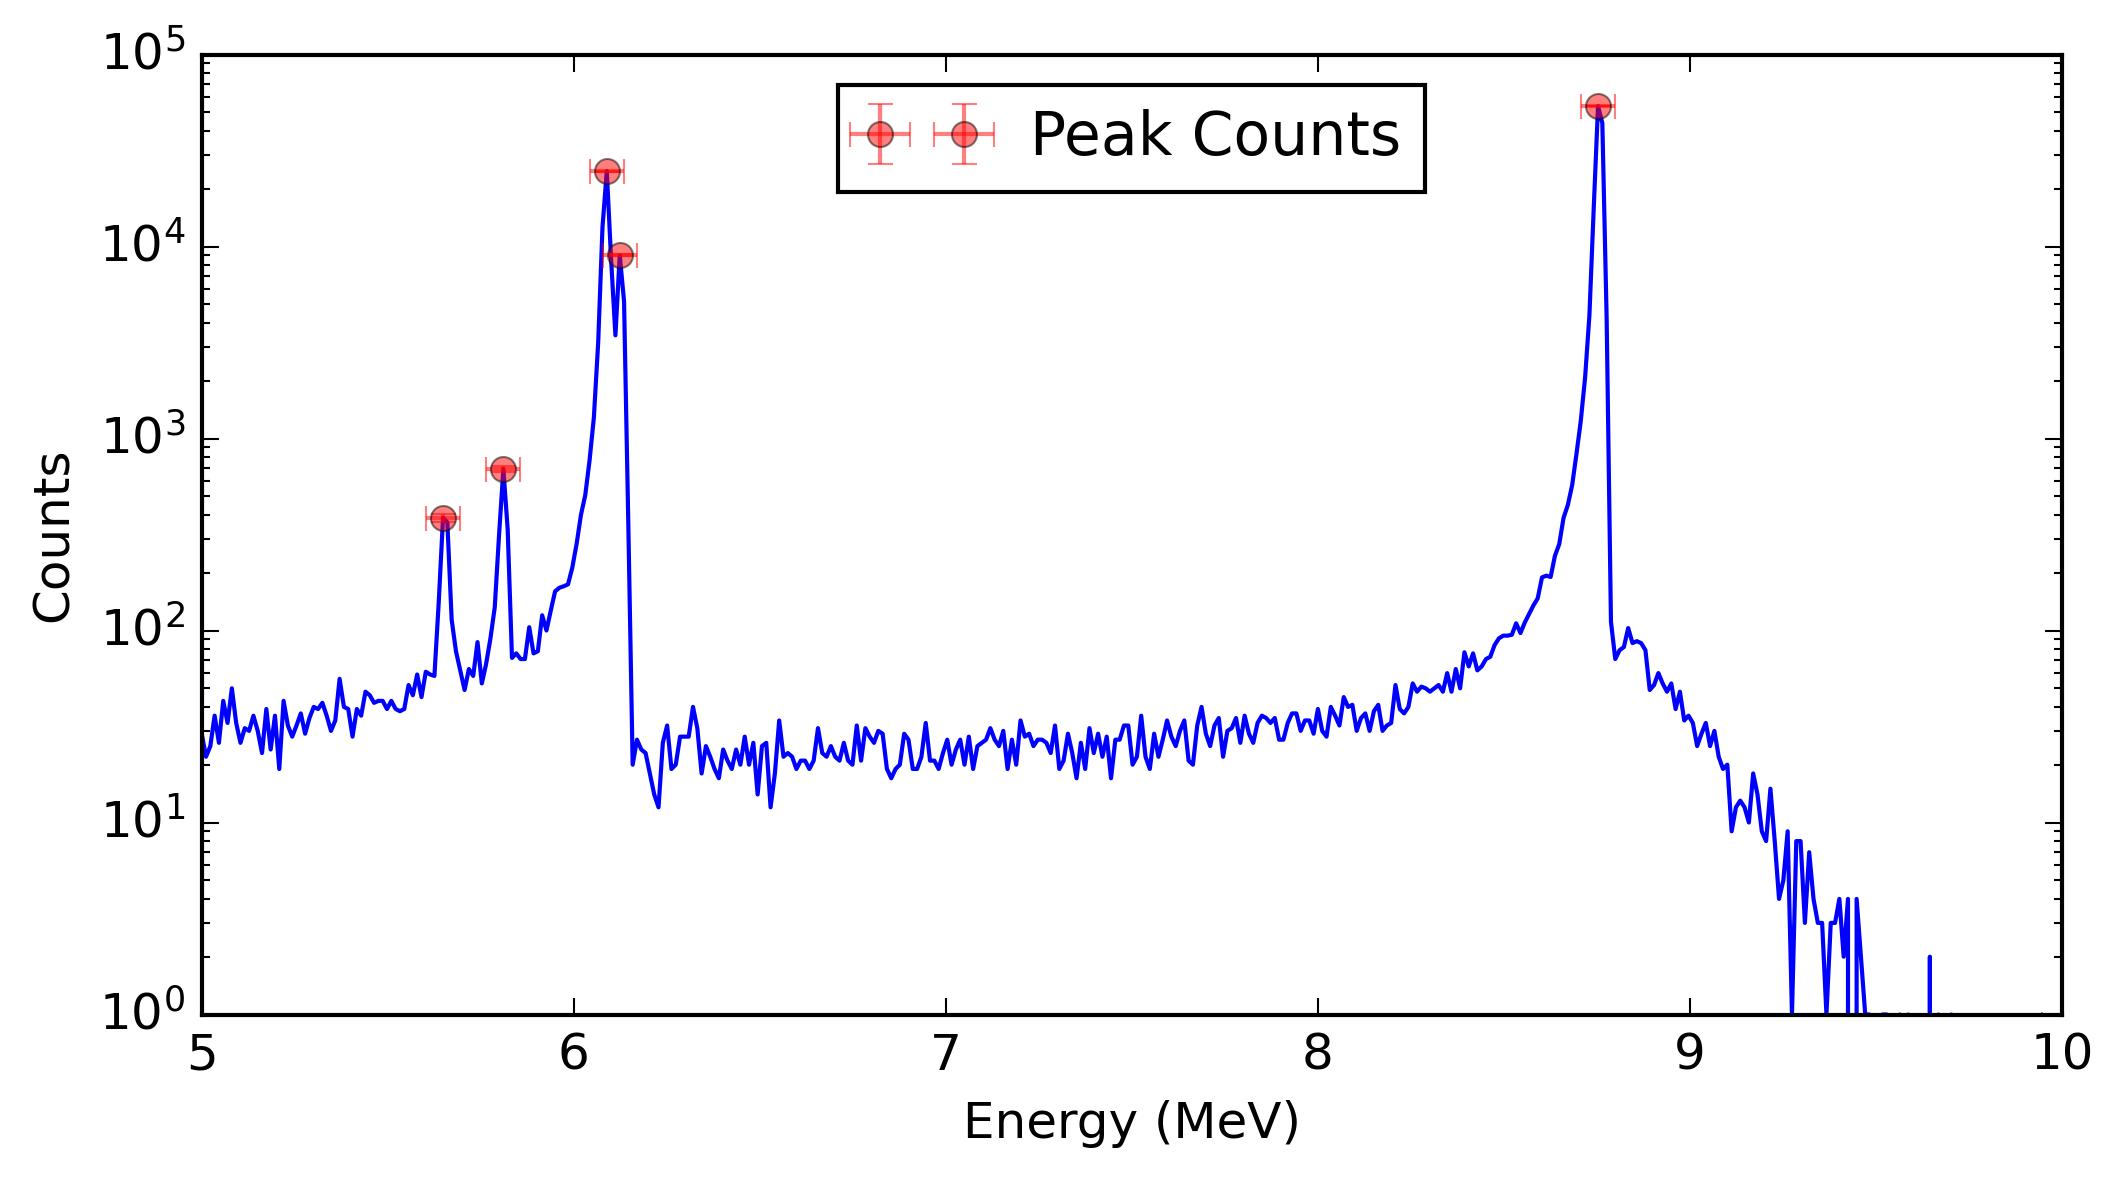

In [10]:
plt.figure(figsize=(8, 4), dpi = 300)
plt.plot(energy, pb_counts)
plt.xlim(5, 10)
plt.semilogy()
plt.xlabel('Energy (MeV)')
plt.ylabel('Counts')


# getting local maxima in spectra
peaks = []
for i in range(1, len(pb_counts) - 1000):
    if pb_counts[i] > 200:
        if pb_counts[i] > pb_counts[i - 1] and pb_counts[i] > pb_counts[i + 1]:
            peaks.append(i)

print(f'The peaks are at channels: {peaks}, corresponding to energies: {energy[peaks]} +- {energy_err[peaks]} MeV.')
plt.errorbar(energy[peaks], pb_counts[peaks], xerr = energy_err[peaks], yerr=np.sqrt(pb_counts[peaks]), fmt='o', color='red', label='Peak Counts', alpha = 0.5)
plt.legend(loc = 'upper center')

In [11]:
# calculate percent error for each
def percent_error(observed, expected):
    return abs(observed - expected) / expected * 100

expected_counts = [5.607, 5.768, 6.08988, 6.05078, 8.78486]
for i in range(len(peaks)):
    observed = energy[peaks[i]]
    expected = expected_counts[i]
    print(f'Percent error for peak {i + 1}: {percent_error(observed, expected)} %')

Percent error for peak 1: 0.7346592198542303 %
Percent error for peak 2: 0.7348246344392206 %
Percent error for peak 3: 0.02383133074190291 %
Percent error for peak 4: 1.1966094042509419 %
Percent error for peak 5: 0.3624738040072717 %


In [12]:
# getting the counts to calculate the relative abundance of each peak
peak_counts = [np.sum(pb_counts[peaks][:-1]), pb_counts[peaks][-1]]
peak_counts_err = np.sqrt(peak_counts)

# relative abundance of each peak
relative_abundance = peak_counts / np.sum(peak_counts) * 100
relative_abundance_err = relative_abundance * np.sqrt((peak_counts_err / peak_counts)**2)

# print results
for i in range(2):
    print(f'Relative abundance of peak {i + 1}: {relative_abundance[i]} +- {relative_abundance_err[i]}')

# percent error with respect to expected values
expected_abundances = []

Relative abundance of peak 1: 39.24897351441592 +- 0.2104116987475566
Relative abundance of peak 2: 60.75102648558408 +- 0.2617776359154954


## Making the multipanel

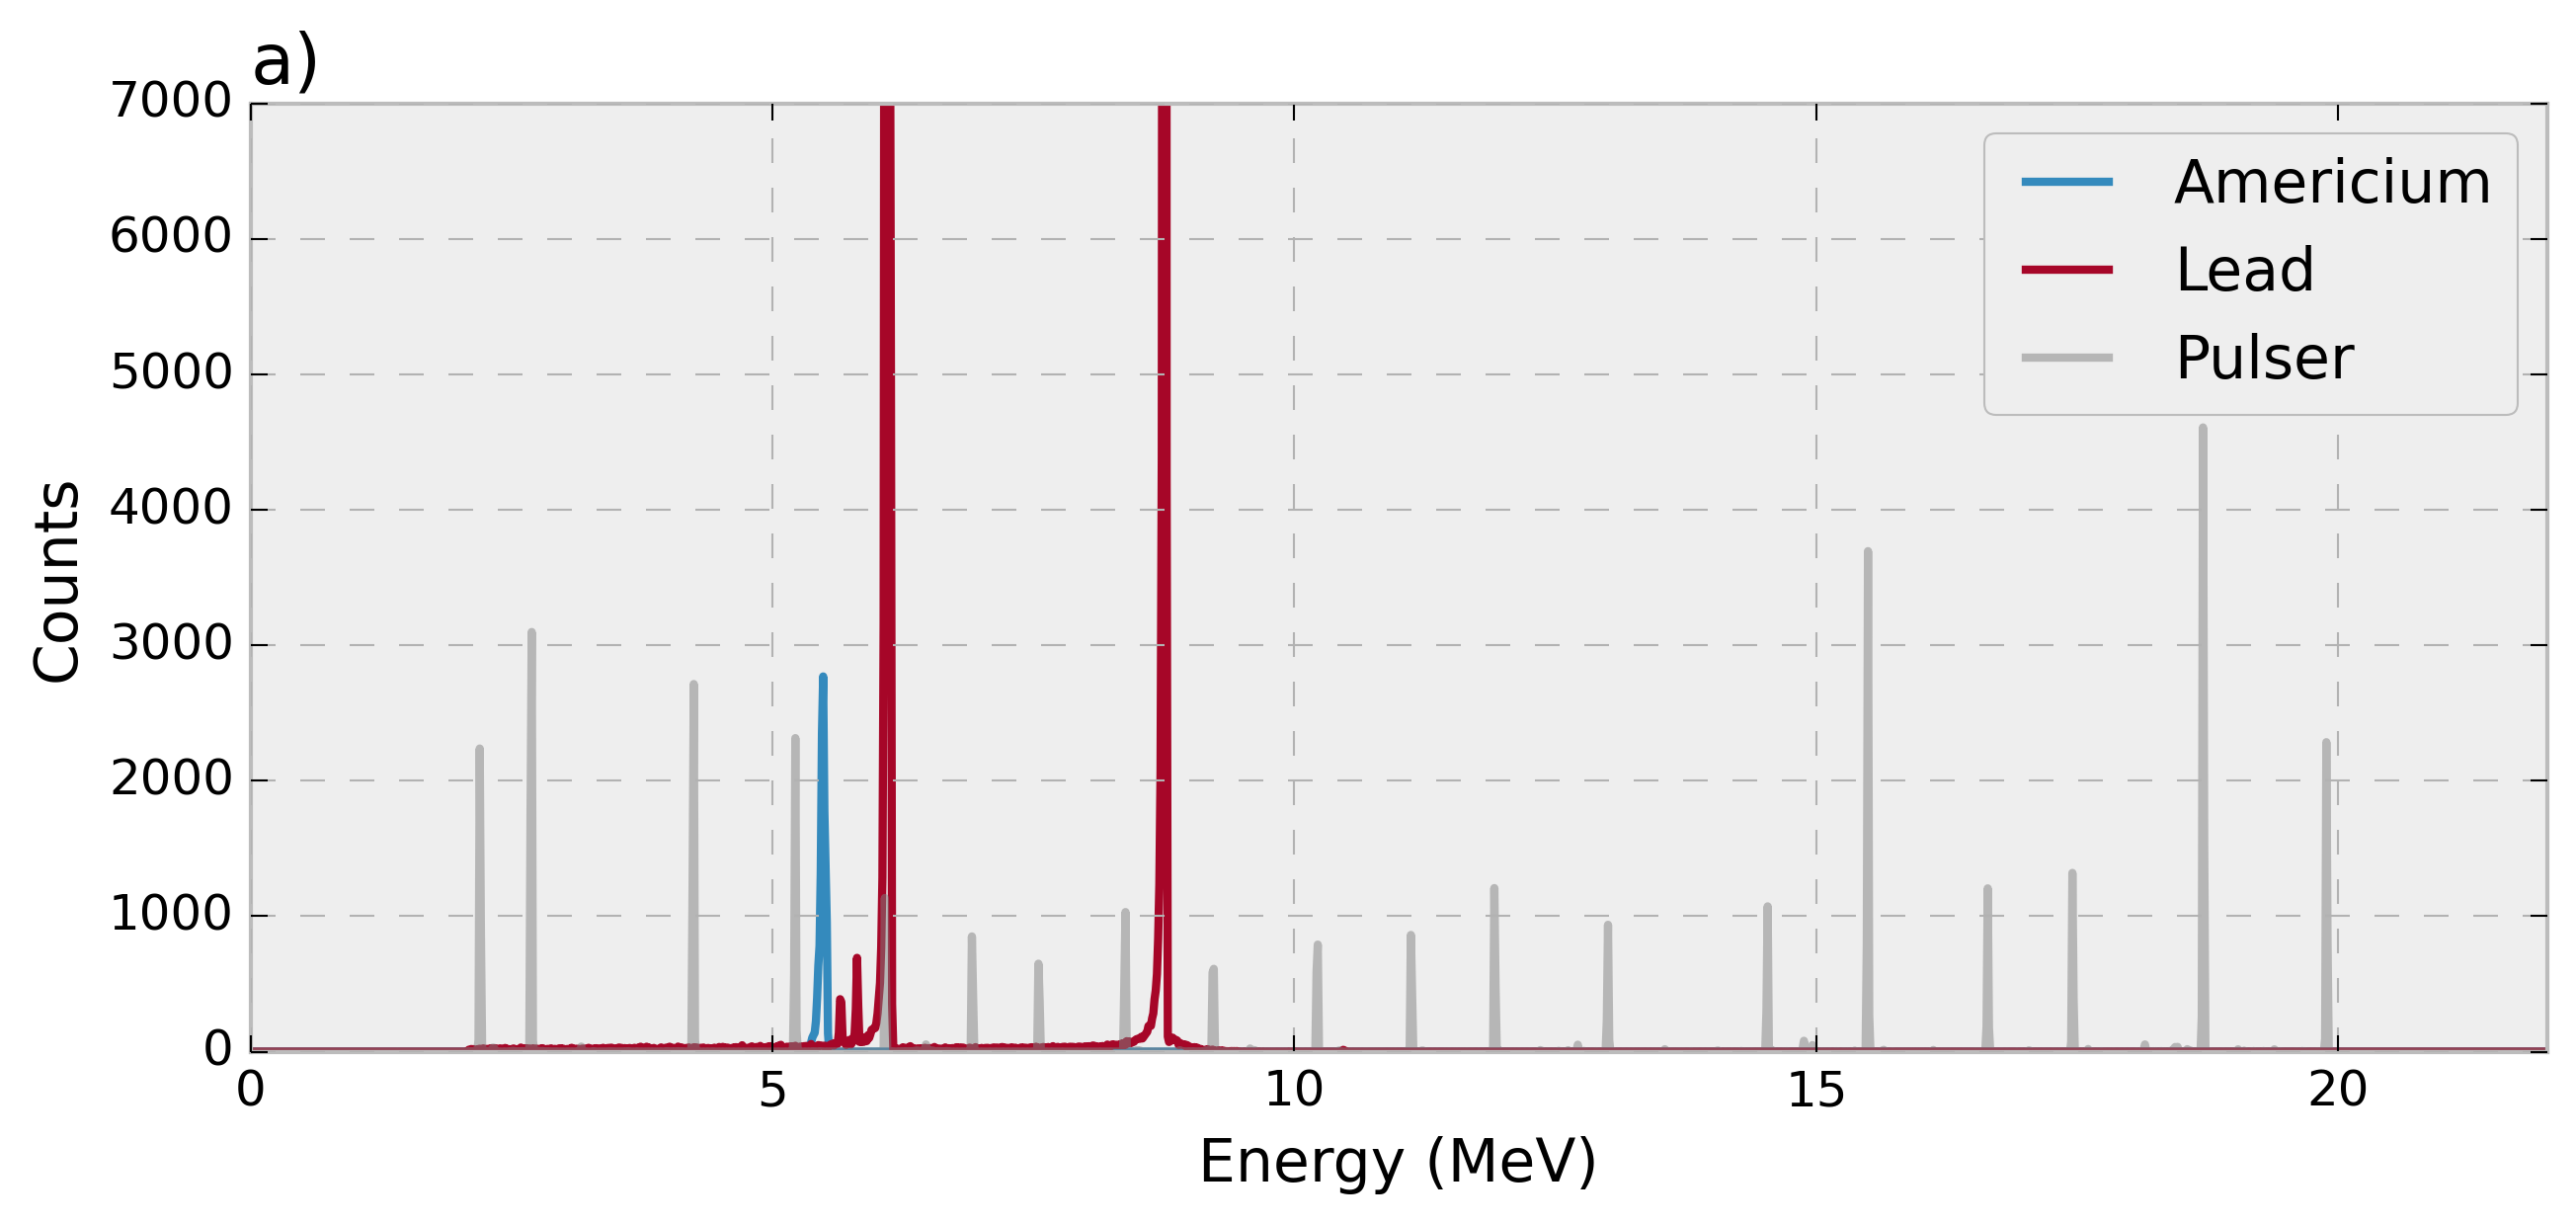

In [13]:
# plotting the spectra with our americium calibration data and the lead data 
plt.style.use('bmh')

plt.figure(figsize = (10, 4), dpi = 300)
plt.plot(energy, am_counts, label='Americium')
plt.plot(energy, pb_counts, label='Lead')
plt.plot(energy, pulser_counts, label='Pulser', color = 'grey', alpha = 0.5)
plt.xlabel('Energy (MeV)')
plt.ylabel('Counts')
plt.legend( loc = 'upper right', frameon = True)
plt.xlim(0, 22)
plt.ylim(0, 7000)
plt.title('a)', loc = 'left')
plt.savefig(user_path + '/PHYS469/alpha_decay/figures/spectra.pdf', bbox_inches='tight')
plt.show()

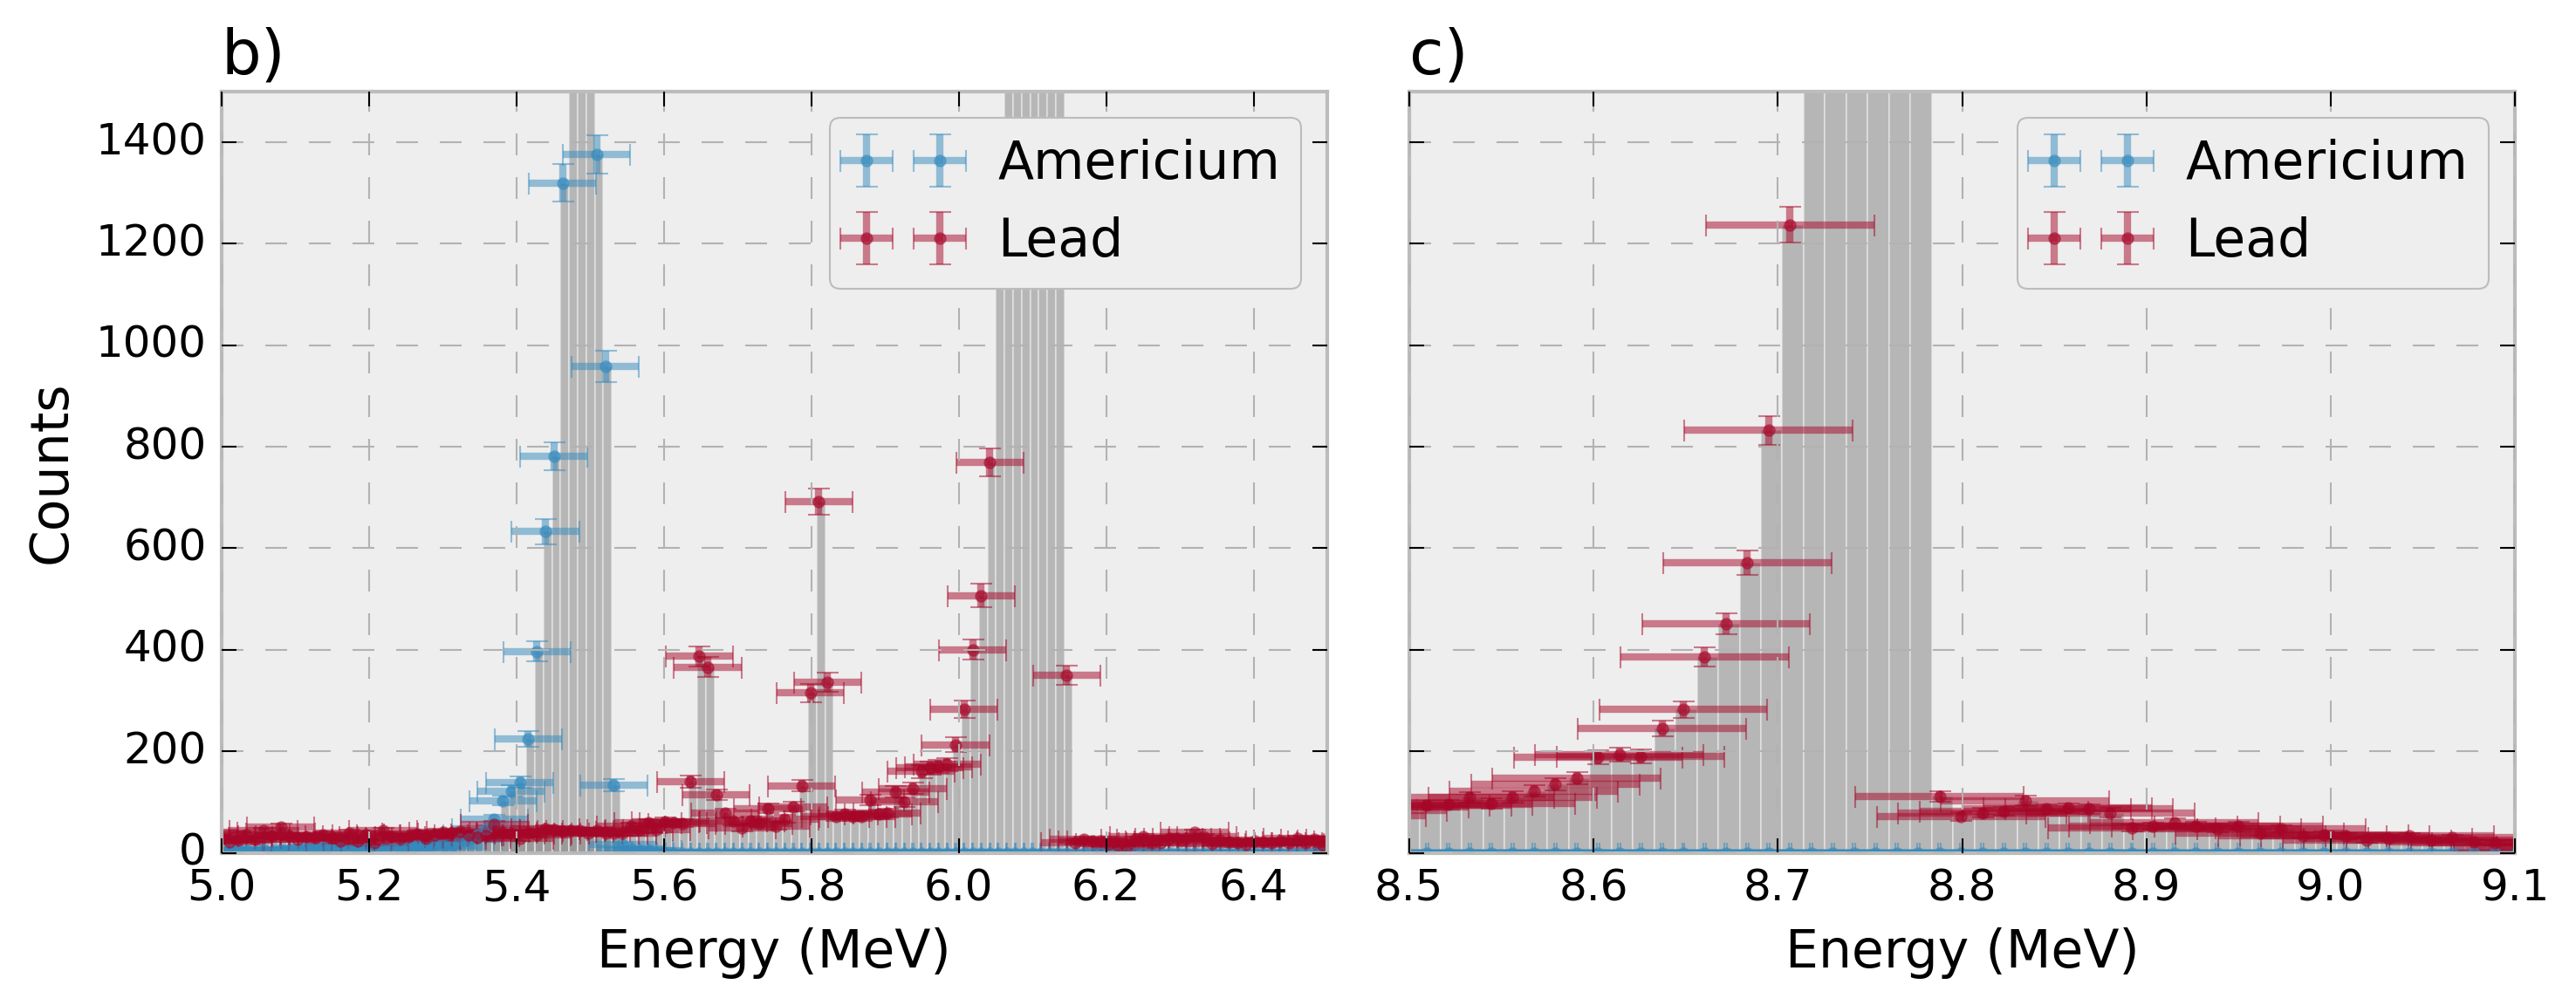

In [15]:
# zooming in on the lead spectrum and plotting  with errors
from importlib import reload
reload(plt)

fig, ax = plt.subplots(1, 2, figsize=(10, 4), dpi=300, sharey=True)

# Left subplot
ax[0].hist(energy, bins=len(channels), weights=pb_counts, color='gray', alpha=0.5)
ax[0].hist(energy, bins=len(channels), weights=am_counts, color='gray', alpha=0.5)
ax[0].errorbar(energy, am_counts, xerr=energy_err, yerr=np.sqrt(am_counts), fmt='.', label='Americium', alpha=0.5)
ax[0].errorbar(energy, pb_counts, xerr=energy_err, yerr=np.sqrt(pb_counts), fmt='.', label='Lead', alpha=0.5)
ax[0].set_xlabel('Energy (MeV)')
ax[0].set_ylabel('Counts')
ax[0].legend(loc='upper right', frameon=True)
ax[0].set_title('b)', loc = 'left')
ax[0].set_xlim(5, 6.5)
ax[0].set_ylim(0, 1500)

# Right subplot
ax[1].hist(energy, bins=len(channels), weights=pb_counts, color='gray', alpha=0.5)
ax[1].hist(energy, bins=len(channels), weights=am_counts, color='gray', alpha=0.5)
ax[1].errorbar(energy, am_counts, xerr=energy_err, yerr=np.sqrt(am_counts), fmt='.', label='Americium', alpha=0.5)
ax[1].errorbar(energy, pb_counts, xerr=energy_err, yerr=np.sqrt(pb_counts), fmt='.', label='Lead', alpha=0.5)
ax[1].set_xlabel('Energy (MeV)')
ax[1].set_title('c)', loc = 'left')
ax[1].legend(loc='upper right', frameon=True)
ax[1].set_xlim(8.5, 9.1)

plt.tight_layout()
plt.savefig(user_path + '/PHYS469/alpha_decay/figures/zoom.pdf', bbox_inches='tight')
plt.show()

## Pressure Analysis

### Path length

In [27]:
"""
(a-b) = 97.06 mm - 6.34 mm (with the Am-sample without spacers)
a-b  + DISTANCE DOWN TO THE PIN (no sample): 110.58 mm - 6.34 mm
"""
a_b = 97.06 - 6.34  # mm
a_b_Am = 97.06 - 6.34  # mm
c = 14.96  # mm
d = 1.06  # mm
f = 4.2  # mm
g =  3  # mm, (approximated by eye)
length_err = 0.01  # mm, all quantities above share this error

s = 50.7  # mm
s_err = 0.02  # mm

dx = a_b - c - d + f + g - s  # mm, distance from source to detector
dx_err = np.sqrt(5 * length_err**2 + s_err**2)  # mm, error propagation
print(f'Path length: {dx} ± {dx_err} mm')

Path length: 31.19999999999999 ± 0.03 mm


### Getting peaks by pressure

In [16]:
def get_peaks(counts):
    # find peaks in the data
    peaks_ind = []
    max_first = np.max(counts[400:600])
    for i in range(1, len(counts) - 1000):
        if counts[i] > max_first-50:
            if counts[i] > counts[i - 1] and counts[i] > counts[i + 1]:
                peaks_ind.append(i)
    
    return peaks_ind

In [32]:
first_peak_energy = []
first_peak_err = []
second_peak_energy = []
second_peak_err = []
pressures = []  # pressures in mbar

for p in pressure_data_dict.keys():
    # convert pressure to mbar
    p_mbar = int(p.split('mbar')[0]) if 'mbar' in p else int(p.split('millitorr')[0])/750.062
    pressures.append(p_mbar)

    # find peaks in the data
    peaks_ind = get_peaks(pressure_data_dict[p].columns['Counts'])
    # print(f'{p}: {peaks}')

    # get the energy of the peaks
    first_peak_energy.append(energy[peaks_ind[0]])
    first_peak_err.append(energy_err[peaks_ind[0]])
    second_peak_energy.append(energy[peaks_ind[1]])
    second_peak_err.append(energy_err[peaks_ind[1]])

# make arrays
# Arrays of the peak energy and error for each pressure, for both lead peaks
pressures = np.array(pressures)
first_peak_energy = np.array(first_peak_energy)
first_peak_err = np.array(first_peak_err)
second_peak_energy = np.array(second_peak_energy)
second_peak_err = np.array(second_peak_err)

### Stopping power

$$ \Delta E = E_{low P} - E_{high P} $$

In [48]:
# Reference energies (E at the lowest P)
lowest_p_ind = np.argmin(np.abs(pressures - 0))
ref_energy_1 = first_peak_energy[lowest_p_ind]
ref_energy_2 = second_peak_energy[lowest_p_ind]

# New energy arrays for delta E = E_ref - E
first_peak_deltaE = ref_energy_1 - first_peak_energy
second_peak_deltaE = ref_energy_2 - second_peak_energy

# Stopping power = delta E / dx
stopping_power_1 = first_peak_deltaE / dx
stopping_power_1_err = np.sqrt((first_peak_err/dx)**2 + (first_peak_deltaE*dx_err/dx**2)**2)
stopping_power_2 = second_peak_deltaE / dx
stopping_power_2_err = np.sqrt((second_peak_err/dx)**2 + (second_peak_deltaE*dx_err/dx**2)**2)

Fitting the data

In [49]:
# Linear fits
def line(x, m, b):
    return m * x + b

# First peak
popt_1, pcov_1 = opt.curve_fit(line, pressures, stopping_power_1, p0=[1, 0])
m1, b1 = popt_1
m_err_1 = np.sqrt(pcov_1[0,0])
b_err_1 = np.sqrt(pcov_1[1,1])
print(f'First peak: m = {m1:.6f} +- {m_err_1:.6f}, b = {b1:.6f} +- {b_err_1:.6f}')

# Second peak
popt_2, pcov_2 = opt.curve_fit(line, pressures, stopping_power_2, p0=[1, 0])
m2, b2 = popt_2
m_err_2 = np.sqrt(pcov_2[0,0])
b_err_2 = np.sqrt(pcov_2[1,1])
print(f'Second peak: m = {m2:.6f} +- {m_err_2:.6f}, b = {b2:.6f} +- {b_err_2:.6f}')

First peak: m = 0.000093 +- 0.000002, b = 0.000298 +- 0.000233
Second peak: m = 0.000070 +- 0.000002, b = 0.000150 +- 0.000203


In [50]:
# Chi square for fits
def reduced_chi2(x_data, y_data, y_err, m, b):
    y_fit = line(x_data, m, b)
    chi2 = np.sum((y_fit - y_data)**2 / y_err**2)
    dof = len(x_data) - 2
    return chi2 / dof

chi2_peak1 = reduced_chi2(pressures, stopping_power_1, stopping_power_1_err, m1, b1)
print(f'Reduced Chi^2 for first peak: {chi2_peak1}')
chi2_peak2 = reduced_chi2(pressures, stopping_power_2, stopping_power_2_err, m2, b2)
print(f'Reduced Chi^2 for second peak: {chi2_peak2}')

# Getting low values possibly because we are overestimating the error in the energy values

Reduced Chi^2 for first peak: 0.1234950417587585
Reduced Chi^2 for second peak: 0.09400448858640063


Theoretical curves

In [92]:
from scipy.constants import e, epsilon_0

T = (22 + 273.15) * u.K
m_alpha = 4.0015 * const.m_p
E0 = m_alpha * const.c**2
E0 = E0.to(u.MeV)
e = e * u.C
I = 85 * u.eV # Mean excitation potential for air
epsilon_0 = epsilon_0 * u.F / u.m

def get_n(P, T=T):
    return P/(const.k_B * T)

def get_beta(E_k, E0=E0):
    E_total = E0 + E_k  # Total energy (GeV)
    beta = np.sqrt(1 - (E0 / E_total)**2)
    if 1 - beta**2 <= 0:
        print("Error: 1 - beta^2 is not positive.")
    return beta

def bethe_manual(P, E_k, I=I, z=2):
    # values for this data
    n = get_n(P)
    beta = get_beta(E_k)

    # bethe formula
    term1 = 4*np.pi/(const.m_e * const.c**2)
    term2 = n*z**2/beta**2
    term3 = (e**2/(4*np.pi*epsilon_0))**2
    term4 = np.log(2*const.m_e*const.c**2*beta**2/(I * (1-beta**2))) - beta**2
    return term1 * term2 * term3 * term4

In [93]:
theory_stopping_power_1 = bethe_manual(pressures * u.mbar, ref_energy_1 * u.MeV)
print(theory_stopping_power_1)
print(stopping_power_1)

[4.53088671e-16 2.11423902e-18 2.26544336e-15 9.06177342e-16
 1.35926601e-15 1.81235468e-15 2.41627317e-17 9.66509267e-19
 4.83254634e-18] C4 s2 mbar / (J kg F2)
[0.00594111 0.         0.02302181 0.01002563 0.01448146 0.01893729
 0.00037132 0.         0.        ]


Plot

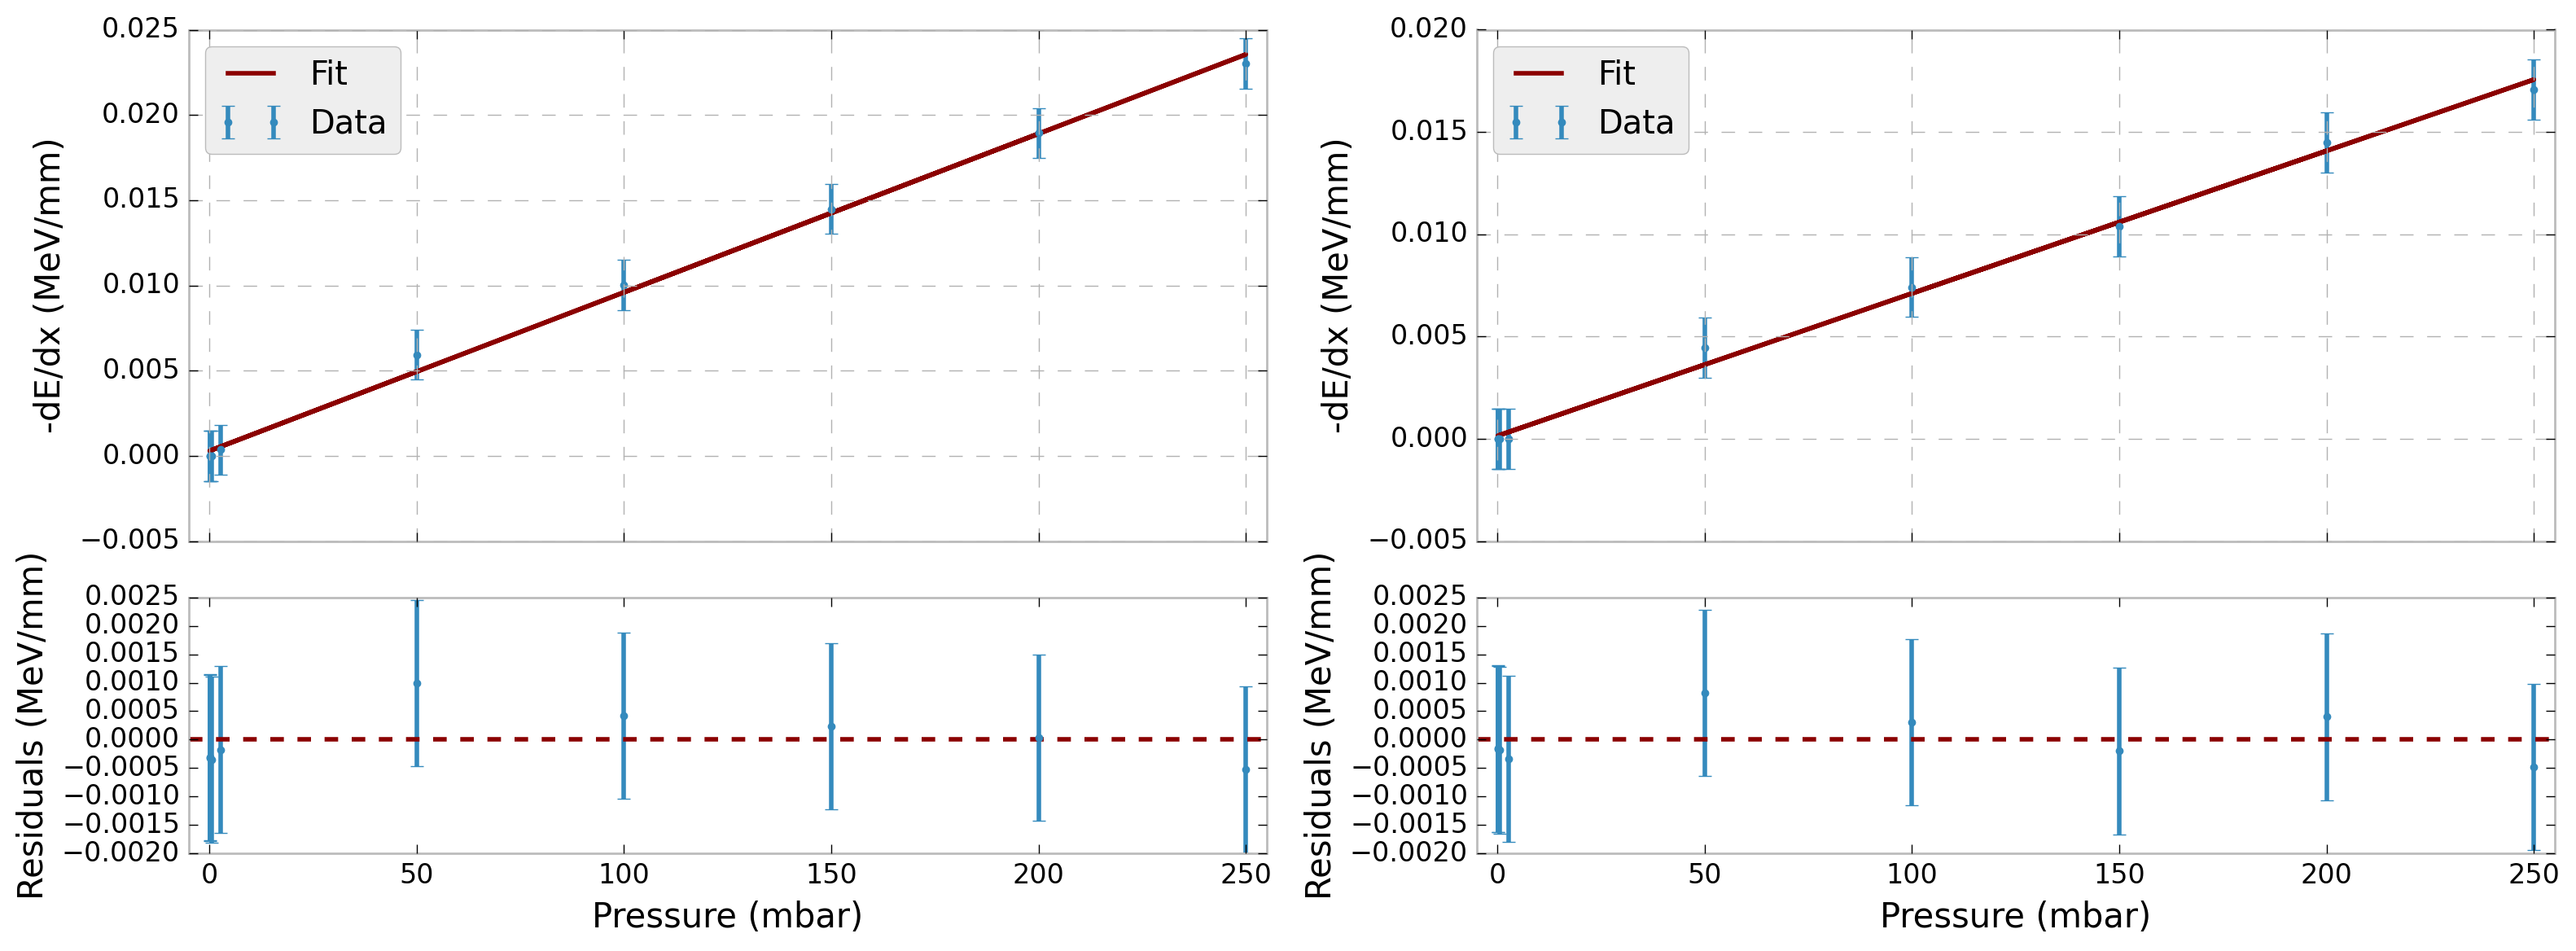

In [39]:
fig, axes = plt.subplots(2, 2, figsize=(16, 6), dpi=200, gridspec_kw={'height_ratios': [2, 1]}, sharex=True)

# First peak
axes[0,0].errorbar(pressures, stopping_power_1, yerr=stopping_power_1_err, fmt='.', label='Data')
axes[0,0].plot(pressures, line(pressures, m1, b1), color='darkred', label='Fit')
# Residuals
axes[1,0].errorbar(pressures, stopping_power_1 - line(pressures, m1, b1), yerr=stopping_power_1_err, fmt='.')
axes[1,0].axhline(0, color='darkred', linestyle='--')

# Second peak
axes[0,1].errorbar(pressures, stopping_power_2, yerr=stopping_power_2_err, fmt='.', label='Data')
axes[0,1].plot(pressures, line(pressures, m2, b2), color='darkred', label='Fit')
# Residuals
axes[1,1].errorbar(pressures, stopping_power_2 - line(pressures, m2, b2), yerr=stopping_power_2_err, fmt='.')
axes[1,1].axhline(0, color='darkred', linestyle='--')

# Labels
for ax in axes[0]:
    ax.set_ylabel('-dE/dx (MeV/mm)', fontsize=15)
    ax.legend(loc='upper left')
    ax.set_facecolor('white')
for ax in axes[1]:
    ax.set_xlim(np.min(pressures)-5,np.max(pressures)+5)
    ax.set_xlabel('Pressure (mbar)', fontsize=15)
    ax.set_ylabel('Residuals (MeV/mm)', fontsize=15)
    ax.set_facecolor('white')
    ax.grid(False)

plt.tight_layout()
plt.show()